In [ ]:
!nvidia-smi

Thu Jan  2 14:54:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install langgraph
!pip install langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from transformers import BarkModel

model = BarkModel.from_pretrained("suno/bark-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/8.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/encodec/modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


generation_config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("suno/bark")

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

speaker_embeddings_path.json:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
# prepare the inputs
text_prompt = "Let's try generating speech, with Bark, a text-to-speech model"
inputs = processor(text_prompt)

# generate speech
speech_output = model.generate(**inputs.to(device))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
from IPython.display import Audio

#sampling_rate = model.generation_config.sample_rate
#Audio(speech_output[0].cpu().numpy(), rate=sampling_rate)

In [ ]:
# Kaggle LLM Architecture (revised slightly)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    # each order is a list of strings
    order: list[str]
    #order: list[tuple]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
AE_JUNG_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Korean street food bot, an interactive Korean restaurant ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. Please ask the customers if they want to eat in the restaurant or to go."
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order."
    #Remove items from the order with remove_items_from_the_order"
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to Ae Jung, an authentic Korean street food restaurant located in the heart of Paris. Type `q` to quit. How may I serve you today?"

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The `pro` models perform the best, especially
# with tool-calling. The `flash` models are super fast, and are a good choice
# if you need to use the higher free-tier quota.
# Check out the features and quota differences here: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [AE_JUNG_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

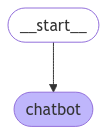

In [ ]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Annyeonghaseyo! Welcome to our Korean street food haven!  I'm your friendly ordering bot. I can tell you about our delicious menu items, help you place your order, and send it to our kitchen.  What would you like to know or order today?  We have a fantastic selection of Tteokbokki, Kimbap, and refreshing drinks!



In [ ]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([AE_JUNG_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

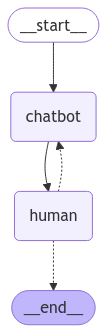

In [ ]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [ ]:
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    1) MENU (including rice and vegetables):
    Yangneom chicken: 11.5 euros
    Ganjang Chicken: 11.5 euros
    Cheese Chicken: 11.5 euros

    2) Tteokbokki: 15 euros
    Cheese Tteokbokki: 17 euros

    3) Korean Chicken by Unit (no MENU):
    Either Yangneom, Ganjang, or Cheese
    => Small (5 pieces): 8 euros
    => Medium (12 pieces): 16 euros
    => Large (22 pieces): 30 euros

    4) Bento Coréen: 14 euros
    3 options: spicy sauce, parmesan, ganjang

    5) Mandu: (5 units)
    7 euros

    6) Corn Dogs (Hallal)
    4 options:
    a) Cheese, Sausage, Potato: 6.5 euros
    b) Cheese, Sausage: 5.5 euros
    c) Cheese, Potato: 6.5 euros
    d) Cheese: 5.5 euros

    7) Drinks

    a) Tea

    3 Bubble tea options (6 euros): Brown sugar Boba pearl milk, matcha boba pearl milk, taro boba pearl milk

    3 Tea options: Ginger, yuza (Korean lemon), green plum
    => iced: 5.5 euros
    => hot: 5 euros

    b) soft drinks (excluding tea): 2 euros
    => Coke: either zero or regular coke
    => Volvic
    => San Pellegrino
    => Lipton Ice Tea

  """

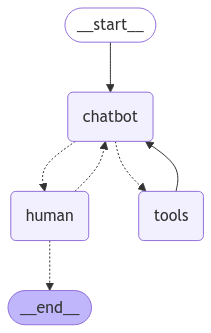

In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([AE_JUNG_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [ ]:
# Remember that you have not implemented ordering yet, so this will loop forever,
# unless you input `q`, `quit` or one of the other exit terms defined in the
# `human_node`.
# Uncomment this line to execute the graph:
state = graph_with_menu.invoke({"messages": []})

# Things to try:
# - I'd love an espresso drink, what have you got?
# - What teas do you have?
# - Can you do a long black? (this is on the menu as an "Americano" - see if it can figure it out)
# - 'q' to exit.


# pprint(state)

Model: Welcome to Ae Jung, an authentic Korean street food restaurant located in the heart of Paris. Type `q` to quit. How may I serve you today?
User: I would like 1 corn dog and 1 coke regular
Model: Certainly!  We have corn dogs and Coke. To clarify, you'd like one corn dog (which type? we have cheese, cheese and sausage, cheese and potato, and cheese, sausage and potato) and one regular Coke?  Please confirm.

User: cheese and sausage please
Model: Okay, one corn dog with cheese and sausage, and one regular Coke.  Anything else?

User: yes, I would like 1 Lipton iced tea
Model: Okay, one corn dog (cheese and sausage), one regular Coke, and one Lipton Iced Tea. Is there anything else you would like to add to your order?



User: please remove the Lipton iced tea
Model: No problem.  Your order will now be one corn dog (cheese and sausage) and one regular Coke. Is this correct?



User: yes
Model: Great! Would you like to dine in or take away?

User: dine in please
Model: Okay, your o

In [ ]:
from collections.abc import Iterable
from random import randint

from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_order(food_drink_item: str, modifiers: Iterable[str]) -> str:
#def add_to_order(food_drink_item: str, modifiers: Iterable[tuple]) -> str:
    """Adds the specified food or drink item to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """

@tool
def remove_items_from_the_order(food_drink_item: str, modifiers: Iterable[str]) -> str:
    """Remove items from the order if the customer wants to remove these items.

    Returns:
      The updated customer order.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line. Each item followed by the quantity in integer number"""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    items_to_remove = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            #print('current order: ' + str(order))

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"



            order.append(f'{tool_call["args"]["food_drink_item"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for food_drink_item in order:
                print(f"  {food_drink_item}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"


        #elif tool_call["name"] == "remove_items_from_the_order":

        #    print(order)

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
        #    modifiers = tool_call["args"]["modifiers"]
        #    modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

        #    print('modifier_str: '  + str(modifier_str))

        #    items_to_remove.append(tool_call["args"]["food_drink_item"])

        #    print('tool_call["args"]["food_drink_item"]: ' + str(tool_call["args"]["food_drink_item"]))

        #    print('items to remove: ' + str(items_to_remove))

            #order.pop(f'{tool_call["args"]["food_drink_item"]} ({modifier_str})')

            #response = "\n".join(order)

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement Korean food.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

            print('Your order will be ready in 5 minutes')

            # prepare the inputs
            #text_prompt = "Your order will be ready in 5 minutes"
            #inputs = processor(text_prompt)
            # generate speech
            #speech_output = model.generate(**inputs.to(device))

            #sampling_rate = model.generation_config.sample_rate
            #return Audio(speech_output[0].cpu().numpy(), rate=sampling_rate)



        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}

def text_to_speech(text):

    #text_prompt = "Your order will be ready in 5 minutes"
    inputs = processor(text)
    # generate speech
    speech_output = model.generate(**inputs.to(device))

    sampling_rate = model.generation_config.sample_rate
    Audio(speech_output[0].cpu().numpy(), rate=sampling_rate)


def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

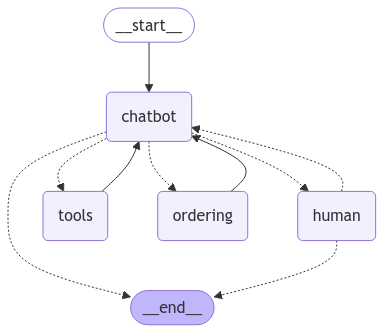

In [ ]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, remove_items_from_the_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [ ]:
# The default recursion limit for traversing nodes is 25 - setting it higher
# means you can try a more complex order with multiple steps and round-trips.
config = {"recursion_limit": 100}

# Uncomment this line to execute the graph:
state = graph_with_order_tools.invoke({"messages": []}, config)

# Things to try:
# - Order a drink!
# - Make a change to your order.
# - "Which teas are from England?"
# - Note that the graph should naturally exit after placing an order.

# pprint(state)

Model: Welcome to Ae Jung, an authentic Korean street food restaurant located in the heart of Paris. Type `q` to quit. How may I serve you today?
User: Hello, I would like 1 corn dog and 1 coke and 1 Lipton Iced Tea please
Model: Certainly!  Let me just confirm: 1 Corn Dog, 1 Coke, and 1 Lipton Iced Tea. Is that correct?  Do you want to eat in or take away?

User: Please remove the Lipton Iced Tea
Model: Okay, so that's 1 Corn Dog and 1 Coke.  Anything else? And for eat in or take away?

User: eat in please
Model: Okay, 1 Corn Dog and 1 Coke, eat in. Is that your final order?

User: yes
current order: []
current order: ['Corn Dog (no modifiers)']
Your order:
  Corn Dog (no modifiers)
  Coke (no modifiers)
Is this correct? yes
Sending order to kitchen!
Corn Dog (no modifiers)
Coke (no modifiers)
Your order will be ready in 5 minutes


In [ ]:

type(state['messages'][-1])

langchain_core.messages.ai.AIMessage

In [ ]:
state['messages'][-1]

AIMessage(content='Great! Your order of 1 Yangneom Korean Chicken, 1 Regular Coke, and 1 Cheese Corn Dog will be ready in approximately 2 minutes. Please find a table and we will bring your order to you. Enjoy your meal! Goodbye!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-1d1397bf-a3e9-4959-b16b-22f010bea481-0', usage_metadata={'input_tokens': 1688, 'output_tokens': 53, 'total_tokens': 1741, 'input_token_details': {'cache_read': 0}})

In [ ]:
inputs = processor(state['messages'][-1].content.replace('\n',''))
# generate speech
speech_output = model.generate(**inputs.to(device))

sampling_rate = model.generation_config.sample_rate
Audio(speech_output[0].cpu().numpy(), rate=sampling_rate)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


# Look at Google Chat API

# To do :

1) More structure to the order

Implement the bot with audio

2) function to remove items from the order

3) Build an app with Mesop

4) Build a backend database for this AI app (use GCP)

5) Try integrate the ai app with Samsung : look at the APIs, Kotlin for Android dev...

6) Build an iOS app with Swift to integrate with: prio

Integrate with Chat API

7) Create website for Ae Jung restaurant

Adding more structure the order (OrderState.order) - e.g. separate fields for item, modifiers and even quantity.


Currently the model can only clear and re-add items, so add a function to remove_items from the order.

# Mesop App

In [ ]:
!pip install mesop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
import mesop as me
import mesop.labs as mel

me.colab_run()


Running server on: http://localhost:32123
 * Serving Flask app 'mesop.server.server'
 * Debug mode: off


In [ ]:
import time

import mesop as me


@me.stateclass
class State:
  input: str
  output: str
  in_progress: bool


@me.page(path="/starter_kit")
def page():
  with me.box(
    style=me.Style(
      background="#fff",
      min_height="calc(100% - 48px)",
      padding=me.Padding(bottom=16),
    )
  ):
    with me.box(
      style=me.Style(
        width="min(720px, 100%)",
        margin=me.Margin.symmetric(horizontal="auto"),
        padding=me.Padding.symmetric(
          horizontal=16,
        ),
      )
    ):
      header_text()
      example_row()
      chat_input()
      output()
  footer()


def header_text():
  with me.box(
    style=me.Style(
      padding=me.Padding(
        top=64,
        bottom=36,
      ),
    )
  ):
    me.text(
      "Mesop Starter Kit",
      style=me.Style(
        font_size=36,
        font_weight=700,
        background="linear-gradient(90deg, #4285F4, #AA5CDB, #DB4437) text",
        color="transparent",
      ),
    )


EXAMPLES = [
  "How to tie a shoe",
  "Make a brownie recipe",
  "Write an email asking for a sick day off",
]


def example_row():
  is_mobile = me.viewport_size().width < 640
  with me.box(
    style=me.Style(
      display="flex",
      flex_direction="column" if is_mobile else "row",
      gap=24,
      margin=me.Margin(bottom=36),
    )
  ):
    for example in EXAMPLES:
      example_box(example, is_mobile)


def example_box(example: str, is_mobile: bool):
  with me.box(
    style=me.Style(
      width="100%" if is_mobile else 200,
      height=140,
      background="#F0F4F9",
      padding=me.Padding.all(16),
      font_weight=500,
      line_height="1.5",
      border_radius=16,
      cursor="pointer",
    ),
    key=example,
    on_click=click_example_box,
  ):
    me.text(example)


def click_example_box(e: me.ClickEvent):
  state = me.state(State)
  state.input = e.key


def chat_input():
  state = me.state(State)
  with me.box(
    style=me.Style(
      padding=me.Padding.all(8),
      background="white",
      display="flex",
      width="100%",
      border=me.Border.all(
        me.BorderSide(width=0, style="solid", color="black")
      ),
      border_radius=12,
      box_shadow="0 10px 20px #0000000a, 0 2px 6px #0000000a, 0 0 1px #0000000a",
    )
  ):
    with me.box(
      style=me.Style(
        flex_grow=1,
      )
    ):
      me.native_textarea(
        value=state.input,
        autosize=True,
        min_rows=4,
        placeholder="Enter your prompt",
        style=me.Style(
          padding=me.Padding(top=16, left=16),
          background="white",
          outline="none",
          width="100%",
          overflow_y="auto",
          border=me.Border.all(
            me.BorderSide(style="none"),
          ),
        ),
        on_blur=textarea_on_blur,
      )
    with me.content_button(type="icon", on_click=click_send):
      me.icon("send")


def textarea_on_blur(e: me.InputBlurEvent):
  state = me.state(State)
  state.input = e.value


def click_send(e: me.ClickEvent):
  state = me.state(State)
  if not state.input:
    return
  state.in_progress = True
  input = state.input
  state.input = ""
  yield

  for chunk in call_api(input):
    state.output += chunk
    yield
  state.in_progress = False
  yield


def call_api(input):
  # Replace this with an actual API call
  time.sleep(0.5)
  yield "Example of streaming an output"
  time.sleep(1)
  yield "\n\nOutput: " + input


def output():
  state = me.state(State)
  if state.output or state.in_progress:
    with me.box(
      style=me.Style(
        background="#F0F4F9",
        padding=me.Padding.all(16),
        border_radius=16,
        margin=me.Margin(top=36),
      )
    ):
      if state.output:
        me.markdown(state.output)
      if state.in_progress:
        with me.box(style=me.Style(margin=me.Margin(top=16))):
          me.progress_spinner()


def footer():
  with me.box(
    style=me.Style(
      position="sticky",
      bottom=0,
      padding=me.Padding.symmetric(vertical=16, horizontal=16),
      width="100%",
      background="#F0F4F9",
      font_size=14,
    )
  ):
    me.html(
      "Made with <a href='https://google.github.io/mesop/'>Mesop</a>",
    )